# Big Data course (a.y. 2020-21) Final Project

In [1]:
from datetime import datetime, timezone
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import scipy.stats
import pyspark
import os

## Introduction

This project will focus on the analysis of the [MovieLens 1M dataset](https://grouplens.org/datasets/movielens/1m/). The dataset contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

The dataset constitues of three DAT files:

- ```movies.dat```

- ```ratings.dat```

- ```users.dat```

##### ```movies.dat```

```movies.dat``` file stores movie information. Data are stored following this format:

**MovieID::Title::Genres**

Titles are identical to titles provided by the IMDB (including year of release).

Genres are pipe-separated and are selected from the following genres:

- Action
- Adventure
- Animation
- Children's
- Comedy
- Crime
- Documentary
- Drama
- Fantasy
- Film-Noir
- Horror
- Musical
- Mystery
- Romance
- Sci-Fi
- Thriller
- War
- Western

Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries

Movies are mostly entered by hand, so errors and inconsistencies may exist.

#### ```ratings.dat```

Ratings are contained in the file ```ratings.dat``` and are stored in the following format:

**UserID::MovieID::Rating::Timestamp**

- UserIDs range between 1 and 6040 

- MovieIDs range between 1 and 3952

- Ratings are made on a 5-star scale (whole-star ratings only)

- Timestamp is represented in seconds since the epoch as returned by ```time(2)```

- Each user has at least 20 ratings

#### ```users.dat```

User information are stored in  ```users.dat``` file. Data are stored with the following format:

**UserID::Gender::Age::Occupation::Zip-code**

All demographic information is provided voluntarily by the users and is not checked for accuracy.  Only users who have provided some demographic information are included in this data set.

Gender is denoted by a "M" for male and "F" for female.

Age is chosen from the following ranges:

- 1:  "Under 18"
- 18:  "18-24"
- 25:  "25-34"
- 35:  "35-44"
- 45:  "45-49"
- 50:  "50-55"
- 56:  "56+"

The occupation is chosen from the following choices:

- 0:  "other" or not specified
- 1:  "academic/educator"
- 2:  "artist"
- 3:  "clerical/admin"
- 4:  "college/grad student"
- 5:  "customer service"
- 6:  "doctor/health care"
- 7:  "executive/managerial"
- 8:  "farmer"
- 9:  "homemaker"
- 10:  "K-12 student"
- 11:  "lawyer"
- 12:  "programmer"
- 13:  "retired"
- 14:  "sales/marketing"
- 15:  "scientist"
- 16:  "self-employed"
- 17:  "technician/engineer"
- 18:  "tradesman/craftsman"
- 19:  "unemployed"
- 20:  "writer"

In [2]:
sc = pyspark.SparkContext(appName="mySparkApp")
movielens_dir = "../data/"

## Exploratory analysis

Load MovieLens data and print the first five values for each file.

In [3]:
movies_data = sc.textFile(os.path.join(movielens_dir, "movies.dat"))\
  .map(lambda x : x.split("::"))
ratings_data = sc.textFile(os.path.join(movielens_dir, "ratings.dat"))\
  .map(lambda x : x .split("::"))
users_data = sc.textFile(os.path.join(movielens_dir, "users.dat"))\
  .map(lambda x : x.split("::"))
print(movies_data.take(5), end="\n\n")
print(ratings_data.take(5), end="\n\n")
print(users_data.take(5))

[['1', 'Toy Story (1995)', "Animation|Children's|Comedy"], ['2', 'Jumanji (1995)', "Adventure|Children's|Fantasy"], ['3', 'Grumpier Old Men (1995)', 'Comedy|Romance'], ['4', 'Waiting to Exhale (1995)', 'Comedy|Drama'], ['5', 'Father of the Bride Part II (1995)', 'Comedy']]

[['1', '1193', '5', '978300760'], ['1', '661', '3', '978302109'], ['1', '914', '3', '978301968'], ['1', '3408', '4', '978300275'], ['1', '2355', '5', '978824291']]

[['1', 'F', '1', '10', '48067'], ['2', 'M', '56', '16', '70072'], ['3', 'M', '25', '15', '55117'], ['4', 'M', '45', '7', '02460'], ['5', 'M', '25', '20', '55455']]


Let's now compute the number of ratings for each movie.

We'll, then, plot the distribution of ratings per movie.

[(1, 2077), (2, 701), (3, 478), (4, 170), (5, 296)]


/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


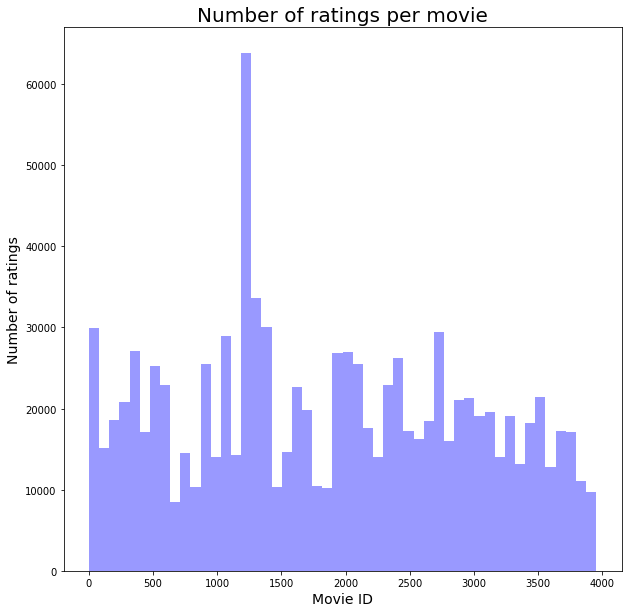

In [4]:
ratingByMovieCount = ratings_data.map(lambda x : (int(x[1]), 1))\
  .reduceByKey(lambda a,b : a + b)\
  .sortByKey()\
  .collect()
print(ratingByMovieCount[:5])

# plot distribution using histogram
ratings = []
for e in ratingByMovieCount:
  for _ in range(e[1]): ratings.append(e[0])
plt.figure(figsize=(10,10))
sns.distplot(ratings, kde=False, hist=True, color="blue")
plt.xlabel("Movie ID", size=14)
plt.ylabel("Number of ratings", size=14)
plt.title("Number of ratings per movie",size=20)
plt.show()


We can now retrieve how many movies each user rated.

We can then plot the number of ratings per user, as done before.

[(1, 53), (2, 129), (3, 51), (4, 21), (5, 198)]


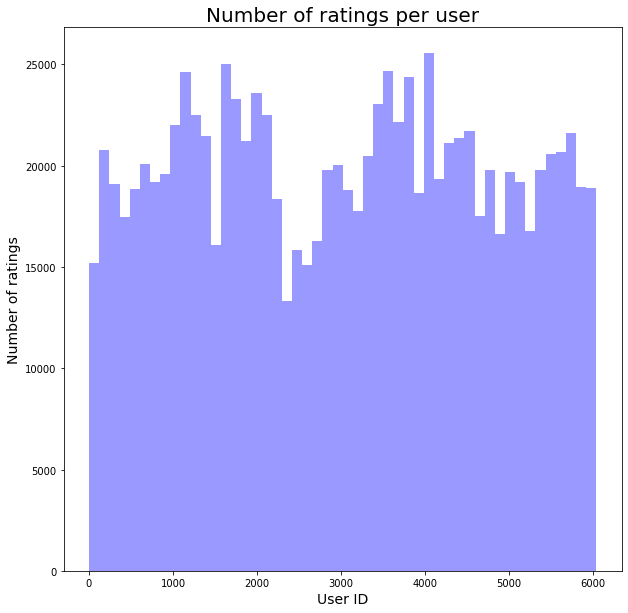

In [5]:
ratingsByUserCount = ratings_data.map(lambda x : (int(x[0]), 1))\
  .reduceByKey(lambda a,b : a + b)\
  .sortByKey()\
  .collect()
print(ratingsByUserCount[:5])

# plot distribution using histogram
ratings = []
for e in ratingsByUserCount:
  for _ in range(e[1]): ratings.append(e[0])
plt.figure(figsize=(10,10))
sns.distplot(ratings, kde=False, hist=True, color="blue")
plt.xlabel("User ID", size=14)
plt.ylabel("Number of ratings", size=14)
plt.title("Number of ratings per user",size=20)
plt.show()

Let's now recover the average rating score received by each movie in MovieLens dataset.

In [6]:
# take those movies with > 1 review
avgScoreByMovie = ratings_data.map(lambda x : (int(x[1]), [int(x[2])]))\
  .reduceByKey(lambda a,b : a + b)\
  .filter(lambda x : len(x[1]) > 1)\
  .map(lambda x : (x[0], np.mean(x[1])))
print(avgScoreByMovie.takeOrdered(10, key = lambda x : -x[1]))  # sort in decreasing order

[(787, 5.0), (3233, 5.0), (3245, 4.8), (53, 4.75), (2503, 4.666666666666667), (2905, 4.608695652173913), (2019, 4.560509554140127), (318, 4.554557700942973), (858, 4.524966261808367), (745, 4.52054794520548)]


We can now recover the average rating score given by each user.

In [7]:
# take those users with > 1 review
avgScoreByUser = ratings_data.map(lambda x : (int(x[0]), [int(x[2])]))\
  .reduceByKey(lambda a,b : a + b)\
  .filter(lambda x : len(x[1]) > 1)\
  .map(lambda x : (x[0], np.mean(x[1])))
print(avgScoreByUser.takeOrdered(10, key = lambda x : -x[1]))  # sort in decreasing order

[(283, 4.962962962962963), (2339, 4.956521739130435), (3324, 4.904761904761905), (3902, 4.890909090909091), (446, 4.8431372549019605), (447, 4.837837837837838), (4649, 4.818181818181818), (4634, 4.813725490196078), (1131, 4.796116504854369), (4925, 4.761904761904762)]


Let's now recover the top $K$ movies (e.g., $K = 10$) having at least $R$ ratings (e.g., $R > 20$), i.e., the $K$ movies with the highest average rating that have at least $R$ reviews.

In [8]:
top10Movies = ratings_data.map(lambda x : (int(x[1]), [int(x[2])]))\
  .reduceByKey(lambda a,b : a + b)\
  .filter(lambda x : len(x[1]) > 20)\
  .map(lambda x : (x[0], np.mean(x[1])))\
  .takeOrdered(10, key = lambda x : -x[1])
top10Movies = sc.parallelize(top10Movies)

# retrieve movies names
movies_names = movies_data.map(lambda x : (int(x[0]), x[1]))\
  .sortByKey()

top10MoviesNames = top10Movies.join(movies_names)\
  .map(lambda x : (x[1][1], x[1][0]))\
  .takeOrdered(10, key = lambda x : -x[1])
print(top10MoviesNames)

[('Sanjuro (1962)', 4.608695652173913), ('Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)', 4.560509554140127), ('Shawshank Redemption, The (1994)', 4.554557700942973), ('Godfather, The (1972)', 4.524966261808367), ('Close Shave, A (1995)', 4.52054794520548), ('Usual Suspects, The (1995)', 4.517106001121705), ("Schindler's List (1993)", 4.510416666666667), ('Wrong Trousers, The (1993)', 4.507936507936508), ('Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)', 4.491489361702127), ('Raiders of the Lost Ark (1981)', 4.477724741447892)]


## Complex queries on the dataset

**Q1 -** Find if there is a correlation between the standard deviation of the ratings a movie has received, and
the number of ratings.

In [9]:
# recover movie ratings 
movieRatings = ratings_data.map(lambda x : (int(x[1]), [int(x[2])]))\
  .reduceByKey(lambda a,b : a + b)\
  .sortByKey()\
  .map(lambda x : (x[0], np.std(x[1])))

# recover number of ratings per movie
ratingNumber = ratings_data.map(lambda x : (int(x[1]), 1))\
  .reduceByKey(lambda a,b : a + b)\
  .sortByKey()

# new RDD with [std[rating[movie]], len(rating[movie])]
movieStdRatingCorr = movieRatings.join(ratingNumber)\
  .sortByKey()\
  .map(lambda x : (x[1][0], x[1][1]))\
  .collect()

# compute Pearson's correlation
stdevs = [e[0] for e in movieStdRatingCorr]
nrats = [e[1] for e in movieStdRatingCorr]
print(scipy.stats.pearsonr(stdevs, nrats))  # corr = 0.022 | P-val = 0.17  --> not correlated

(0.022378105407863134, 0.17319118659128352)


**Q2 -** Find the evolution over time (with a granularity of N months) of the number of ratings and the average
rating: do high rated movies maintain their ratings? Are low rated movies “abandoned” after a while?

High rated movies:	1311
Constantly highly rated movies:	40
[(2, 10), (3, 10), (4, 9), (5, 10), (7, 10)]


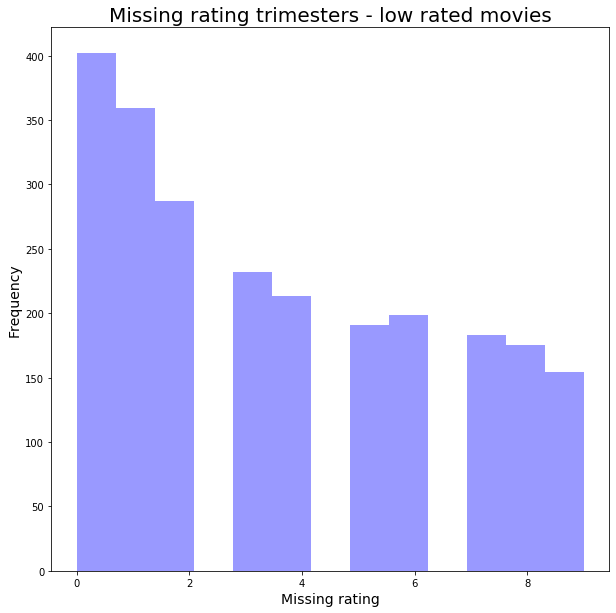

In [10]:
# assume granularity of N == 4 months
def getYear(timestamp):
    if not isinstance(timestamp, int):
        raise TypeError("Expected int, got {}".format(type(timestamp).__name__))
    dt = datetime.fromtimestamp(timestamp, timezone.utc)  # retrieve datetime object from timestamp
    if dt.month >= 1 and dt.month < 5: m = 1
    if dt.month >= 5 and dt.month < 9: m = 2
    if dt.month >= 9 and dt.month < 13: m = 3
    return "{}-{}".format(dt.year, m)

# average rating
avgRatingMov = ratings_data.map(lambda x : ((int(x[1]), getYear(int(x[3]))), [int(x[2])]))\
    .reduceByKey(lambda a,b: a + b)\
    .map(lambda x : (x[0][0], [np.mean(x[1])]))\
    .reduceByKey(lambda a,b : a + b)\
    .sortByKey()

# assumes that movies are high rated if have at least one avg rating > 4
hratedmov = avgRatingMov.filter(lambda x : any([r > 4 for r in x[1]]))
print("High rated movies:\t%d" % (hratedmov.count()))
hratedmovConst = hratedmov.filter(lambda x : all([r > 4 for r in x[1]]))
print("Constantly highly rated movies:\t%d" % (hratedmovConst.count()))

# number of ratings
ratingsNumber = ratings_data.map(lambda x : ((int(x[1]), getYear(int(x[3]))), 1))\
    .reduceByKey(lambda a,b : a + b)\
    .sortByKey()
lratedmov = avgRatingMov.filter(lambda x : all([r <= 4 for r in x[1]]))\
    .map(lambda x : int(x[0]))\
    .collect()
ratingsNumberlrated = ratingsNumber.filter(lambda x : x[0][0] in lratedmov)\
    .map(lambda x : (x[0][0], [(x[0][1], x[1])]))\
    .reduceByKey(lambda a,b : a + b)\
    .map(lambda x : (x[0], len(x[1])))\
    .sortByKey()\
    .collect()
print(ratingsNumberlrated[:5])

def abandonedMov(movlst):
    nratings = []
    for tup in movlst: nratings.append(tup[1])
    max_nratings = max(nratings)
    diff_nratings = [max_nratings - tup[1] for tup in movlst]
    plt.figure(figsize=(10,10))
    sns.distplot(diff_nratings, kde=False, hist=True, color="blue")
    plt.xlabel("Missing rating", size=14)
    plt.ylabel("Frequency", size=14)
    plt.title("Missing rating trimesters - low rated movies",size=20)
    plt.show()
abandonedMov(ratingsNumberlrated)

**Q3 -** Find how the average rating of each movie changes as we progressively remove the ratings from users that rated more and more movies. For instance, we can identify different groups of users (who rated less than 10 movies, who rated between 11 and 30 movies, ...) and we can compute the average rating
considering all the groups, then only the groups of users with at least 11 ratings, and so forth.

In [11]:
# divide users in groups based on the number of reviews
# NB each user rated each movie at most once
userNratings = ratings_data.map(lambda x : (int(x[0]), 1))\
    .reduceByKey(lambda a,b : a + b)

# divide users in 6 categories (based on number of reviews)
user20 = userNratings.filter(lambda x : x[1] < 21 and x[1] > 0)
user40 = userNratings.filter(lambda x : x[1] < 41 and x[1] > 20)
user60 = userNratings.filter(lambda x : x[1] < 61 and x[1] > 40)
user80 = userNratings.filter(lambda x : x[1] < 81 and x[1] > 60)
user100 = userNratings.filter(lambda x : x[1] < 101 and x[1] > 80)
userMore = userNratings.filter(lambda x : x[1] > 100)
print(
    "Users with 20 or less reviews: %d" % (user20.count()),
    "Users with between 21 and 40 reviews: %d" % (user40.count()),
    "Users with between 41 and 60 reviews: %d" % (user60.count()),
    "Users with between 61 and 80 reviews: %d" % (user80.count()),
    "Users with between 81 and 100 reviews: %d" % (user100.count()),
    "Users with 101 or more reviews: %d" % (userMore.count()),
    sep="\n"
)

# get average rating considering all groups
avgRatingTot = ratings_data.map(lambda x : (int(x[1]), [int(x[2])]))\
    .reduceByKey(lambda a,b : a + b)\
    .map(lambda x : (x[0], np.mean(x[1])))\
    .sortByKey()
print(
    "\nAverage score accounting for ratings from all users:\n",
    avgRatingTot.take(5)
)

# get average rating per user group
user20lst = user20.map(lambda x : x[0])\
    .collect()
avgRatingUser20 = ratings_data.filter(lambda x : int(x[0]) in user20lst)\
    .map(lambda x : (int(x[1]), [int(x[2])]))\
    .reduceByKey(lambda a,b : a + b)\
    .map(lambda x : (x[0], np.mean(x[1])))\
    .sortByKey()
# for this group some movies are missing
print(
    "\nAverage score accounting for ratings from users with 20 or less reviews:\n",
    avgRatingUser20.take(5)
)
user40lst = user40.map(lambda x : x[0])\
    .collect()
avgRatingUser40 = ratings_data.filter(lambda x : int(x[0]) in user40lst)\
    .map(lambda x : (int(x[1]), [int(x[2])]))\
    .reduceByKey(lambda a,b : a + b)\
    .map(lambda x : (x[0], np.mean(x[1])))\
    .sortByKey()
print(
    "\nAverage score accounting for ratings from users with between 21 and 40 reviews:\n",
    avgRatingUser40.take(5)
)
user60lst = user60.map(lambda x : x[0])\
    .collect()
avgRatingUser60 = ratings_data.filter(lambda x : int(x[0]) in user60lst)\
    .map(lambda x : (int(x[1]), [int(x[2])]))\
    .reduceByKey(lambda a,b : a + b)\
    .map(lambda x : (x[0], np.mean(x[1])))\
    .sortByKey()
print(
    "\nAverage score accounting for ratings from users with between 41 and 60 reviews:\n",
    avgRatingUser60.take(5)
)
user80lst = user80.map(lambda x : x[0])\
    .collect()
avgRatingUser80 = ratings_data.filter(lambda x : int(x[0]) in user80lst)\
    .map(lambda x : (int(x[1]), [int(x[2])]))\
    .reduceByKey(lambda a,b : a + b)\
    .map(lambda x : (x[0], np.mean(x[1])))\
    .sortByKey()
print(
    "\nAverage score accounting for ratings from users with between 61 and 80 reviews:\n",
    avgRatingUser80.take(5)
)
user100lst = user100.map(lambda x : x[0])\
    .collect()
avgRatingUser100 = ratings_data.filter(lambda x : int(x[0]) in user100lst)\
    .map(lambda x : (int(x[1]), [int(x[2])]))\
    .reduceByKey(lambda a,b : a + b)\
    .map(lambda x : (x[0], np.mean(x[1])))\
    .sortByKey()
print(
    "\nAverage score accounting for ratings from users with between 81 and 100 reviews:\n",
    avgRatingUser100.take(5)
)
userMorelst = userMore.map(lambda x : x[0])\
    .collect()
avgRatingUserMore = ratings_data.filter(lambda x : int(x[0]) in userMorelst)\
    .map(lambda x : (int(x[1]), [int(x[2])]))\
    .reduceByKey(lambda a,b : a + b)\
    .map(lambda x : (x[0], np.mean(x[1])))\
    .sortByKey()
print(
    "\nAverage score accounting for ratings from users with 101 or more reviews:\n",
    avgRatingUserMore.take(5)
)

Users with 20 or less reviews: 86
Users with between 21 and 40 reviews: 1265
Users with between 41 and 60 reviews: 776
Users with between 61 and 80 reviews: 578
Users with between 81 and 100 reviews: 426
Users with 101 or more reviews: 2909

Average score accounting for ratings from all users:
 [(1, 4.146846413095811), (2, 3.20114122681883), (3, 3.01673640167364), (4, 2.7294117647058824), (5, 3.0067567567567566)]

Average score accounting for ratings from users with 20 or less reviews:
 [(1, 3.875), (3, 3.0), (4, 3.0), (7, 4.0), (10, 3.0)]

Average score accounting for ratings from users with between 21 and 40 reviews:
 [(1, 4.109090909090909), (2, 3.0), (3, 3.16), (4, 2.6666666666666665), (5, 2.888888888888889)]

Average score accounting for ratings from users with between 41 and 60 reviews:
 [(1, 4.083969465648855), (2, 3.526315789473684), (3, 3.2), (4, 3.6666666666666665), (5, 3.0)]

Average score accounting for ratings from users with between 61 and 80 reviews:
 [(1, 4.138686131386

**Q4 -** Is it possible to identify groups of similar movies based on the ratings they received from the users? For instance, if movies m1 and m2 have both obtained 5 stars from users u1 and u2, they may be
considered similar.

In [12]:
# recover ratings grouped by movie id and user id
movieRatings = ratings_data.map(lambda x : (int(x[0]), [(int(x[1]), int(x[2]))]))\
    .reduceByKey(lambda a,b : a + b)\
    .sortByKey()\
    .collect()
# map movie ids to titles
moviesIdTitle = movies_data.map(lambda x : (int(x[0]), x[1]))\
    .collect()
moviesIdTitleMap = {}
for t in moviesIdTitle:
    assert t[0] not in moviesIdTitleMap.keys()
    moviesIdTitleMap.update({t[0]:t[1]})
# create dataframe
data = {}
for t in movieRatings:
    user = t[0]
    assert user not in data.keys()
    data.update({user:{}})
    ratings = t[1]
    for t2 in ratings:
        title = moviesIdTitleMap[t2[0]]
        rating = t2[1]
        assert title not in data[user].keys()
        data[user].update({title:rating})
movies = pd.DataFrame(data)
# fill NaNs with column mean
movies.fillna(movies.mean(), inplace=True)
movies.head()

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
"$1,000,000 Duck (1971)",4.188679,3.713178,3.901961,4.190476,3.146465,3.901408,4.322581,3.884892,3.735849,4.114713,...,3.666667,4.134615,3.85,4.095238,2.610714,3.302928,3.717822,3.8,3.878049,3.577713
'Night Mother (1986),4.188679,3.713178,3.901961,4.190476,3.146465,3.901408,4.322581,3.884892,3.735849,4.114713,...,3.666667,4.134615,3.85,4.095238,2.610714,3.000000,3.717822,3.8,3.878049,3.577713
'Til There Was You (1997),4.188679,3.713178,3.901961,4.190476,3.146465,3.901408,4.322581,3.884892,3.735849,4.114713,...,3.666667,4.134615,3.85,4.095238,2.610714,3.302928,3.717822,3.8,3.878049,3.577713
"'burbs, The (1989)",4.188679,3.713178,3.901961,4.190476,3.146465,3.901408,4.322581,3.884892,3.735849,4.000000,...,3.666667,4.134615,3.85,4.095238,2.610714,3.302928,3.717822,3.8,3.878049,3.577713
...And Justice for All (1979),4.188679,3.713178,3.901961,4.190476,3.146465,3.901408,4.322581,3.884892,3.735849,4.114713,...,3.666667,4.134615,3.85,4.095238,2.610714,3.302928,3.717822,3.8,3.878049,3.577713


Let's apply K-means clustering algorithm to identify groups of movies with similar ratings by users.

For plotting purposes we first consider only users 4169 and 1680 ratings (users with highest number of ratings). Then, we will compute clusters considering all users' ratings.

Text(0.5, 1.0, 'Movie ratings clusters')

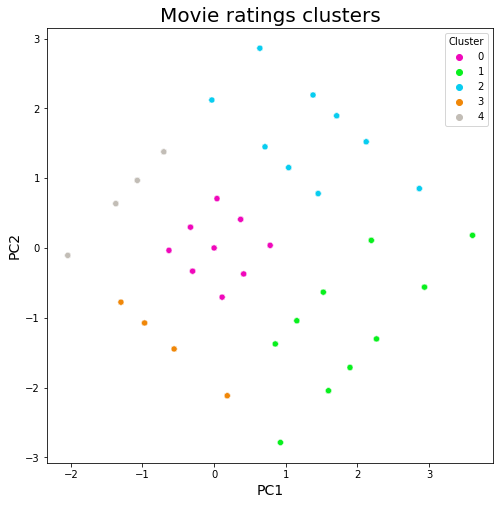

In [13]:
# perform K-means clustering on user 4169 and 2680 ratings
kmeans = KMeans(n_clusters=5)  # assume 5 clusters
cls = kmeans.fit_predict(movies[[4169,1680]])
movies['Cluster'] = cls
# compute PCs
pca = PCA(n_components=2)
pcs = pca.fit_transform(movies[[4169,1680]])
moviesPC = pd.DataFrame(
    data = pcs, 
    columns = ["PC1", "PC2"], 
    index=movies.index.tolist()
)
moviesPC["Cluster"] = movies.Cluster
plt.figure(figsize=(8,8))
palette = ["#F008BB", "#08F01D", "#08CDF0", "#F08708", "#C2BDB6"]
sns.scatterplot(data=moviesPC, x="PC1", y="PC2", hue="Cluster", palette=palette)
plt.xlabel("PC1", size=14)
plt.ylabel("PC2", size=14)
plt.title("Movie ratings clusters", size=20)

Text(0.5, 1.0, 'Movie ratings clusters')

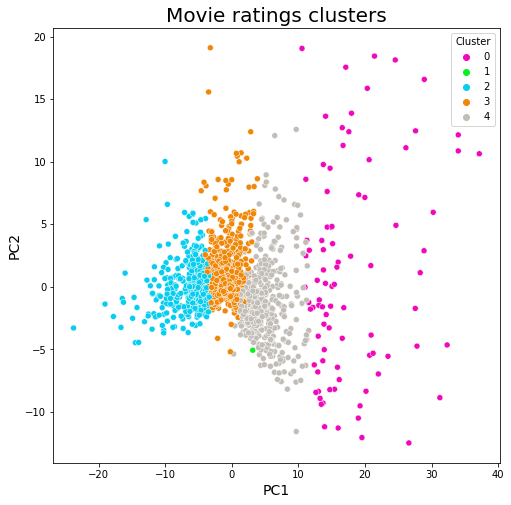

In [14]:
# perform K-means clustering on all users' ratings
kmeans = KMeans(n_clusters=5)  # assume 5 clusters
cls = kmeans.fit_predict(movies[movies.columns.tolist()])
movies['Cluster'] = cls
# compute PCs
pca = PCA(n_components=2)
pcs = pca.fit_transform(movies)
moviesPC = pd.DataFrame(
    data = pcs, 
    columns = ["PC1", "PC2"], 
    index=movies.index.tolist()
)
moviesPC["Cluster"] = movies.Cluster
plt.figure(figsize=(8,8))
palette = ["#F008BB", "#08F01D", "#08CDF0", "#F08708", "#C2BDB6"]
sns.scatterplot(data=moviesPC, x="PC1", y="PC2", hue="Cluster", palette=palette)
plt.xlabel("PC1", size=14)
plt.ylabel("PC2", size=14)
plt.title("Movie ratings clusters", size=20)